In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
git config --global user.email "Juergengeorge50@gmail.com"

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np


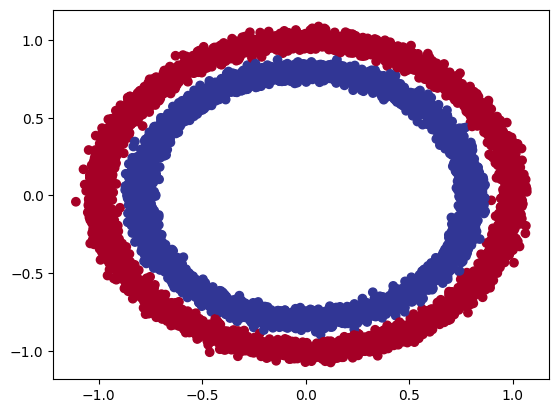

In [2]:
# generate non-linear data

from sklearn.datasets import make_circles
n_samples = 10000

X,y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.RdYlBu, c=y)

In [3]:
#convert data to Tensor and split data

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"X train:{len(X_train)}, X_test:{len(X_test)}, y_train:{len(y_train)}, y_test:{len(y_test)}")

print(f"{X_train[:5]}, {y_train[:5]}")

X train:8000, X_test:2000, y_train:8000, y_test:2000
tensor([[ 0.2029, -1.0081],
        [-0.1717, -0.9750],
        [ 0.5565,  0.5440],
        [ 0.1194, -1.0153],
        [ 0.3515,  0.7450]]), tensor([0., 0., 1., 0., 1.])


In [4]:
class CircleModel(nn.Module):
  def __init__(self, hidden_size,input_size):
    super().__init__()
    self.hidden_layers = nn.Sequential(
        *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        for _ in range(64)]

    )

    self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.output_layer = nn.Linear(hidden_size, out_features=1)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.hidden_layers(x)
    x = self.output_layer(x)
    return torch.sigmoid(x)

In [5]:
torch.manual_seed(42)
model2 = CircleModel(hidden_size=10, input_size=2)
# model2

In [6]:
# optimizer and loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.001)

Epoch: 0 | Train Loss: 0.730 | Test Loss: 0.734
Epoch: 20 | Train Loss: 0.727 | Test Loss: 0.731
Epoch: 40 | Train Loss: 0.724 | Test Loss: 0.728
Epoch: 60 | Train Loss: 0.721 | Test Loss: 0.725
Epoch: 80 | Train Loss: 0.717 | Test Loss: 0.721
Epoch: 100 | Train Loss: 0.710 | Test Loss: 0.713
Epoch: 120 | Train Loss: 0.700 | Test Loss: 0.701
Epoch: 140 | Train Loss: 0.694 | Test Loss: 0.695
Epoch: 160 | Train Loss: 0.693 | Test Loss: 0.694
Epoch: 180 | Train Loss: 0.693 | Test Loss: 0.693


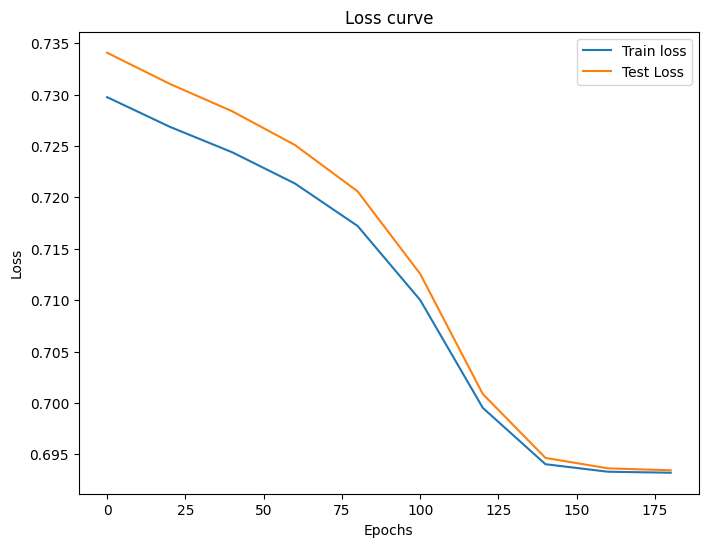

In [7]:
# train loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model2.train()

  # 1. Forward pass
  y_logits = model2(X_train).squeeze() # to remove extra dimensions
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_train)

  # 3. Optimizer, backward propagation and then optimizer based on the backward propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)

  # Print out what's happening
  if epoch % 20 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().cpu().numpy()) # detach to remove gradient trackng, to cpu if on gpu, to numpy for matplot
    test_loss_values.append(test_loss.detach().cpu().numpy())
    print(f"Epoch: {epoch} | Train Loss: {loss:.3f} | Test Loss: {test_loss:.3f}")

# Plot the loss curves
plt.figure(figsize=(8,6))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [8]:
# Helper function to plot a decision boundary
def plot_decision_boundary(model, X, y):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source: https://towardsdatascience.com/how-to-visualize-a-decision-boundary-for-machine-learning-models-and-why-b71a6863b815
    """
    # 0. Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # 1. Make predictions on grid
    model.eval()
    with torch.inference_mode():
        y_pred = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).squeeze()

    # 2. Change preds from logits/probabilities to labels
    y_pred = torch.round(torch.sigmoid(y_pred))

    # 3. Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

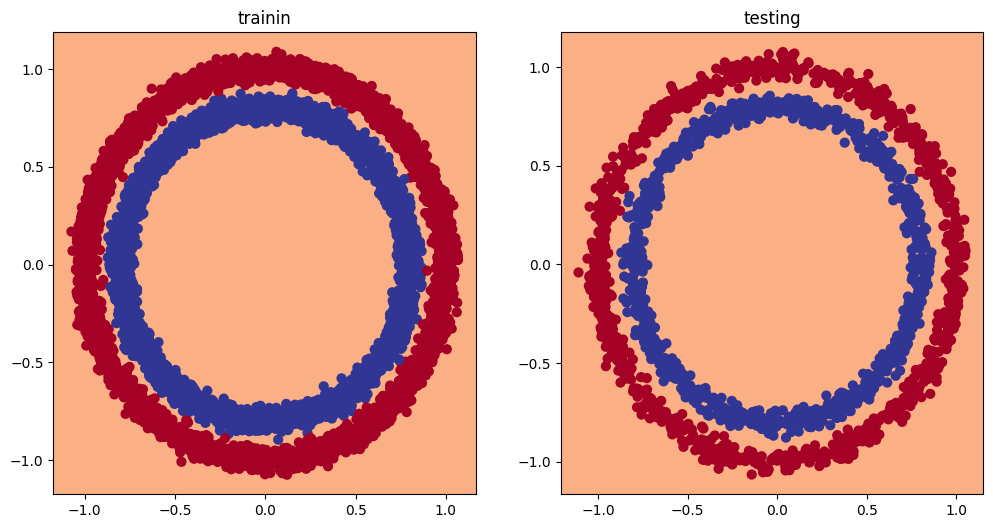

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model2, X_train, y_train)
plt.title("trainin")

plt.subplot(1, 2, 2)
plot_decision_boundary(model2, X_test, y_test)
plt.title("testing")

plt.show()

## comment
The model loss curve plateus after but no problem. the prediction is perfect
